## Данные

Данные в [архиве](https://drive.google.com/file/d/15o7fdxTgndoy6K-e7g8g1M2-bOOwqZPl/view?usp=sharing). В нём два файла:
- `news_train.txt` тренировочное множество
- `news_test.txt` тренировочное множество

С некоторых новостных сайтов были загружены тексты новостей за период  несколько лет, причем каждая новость принаделжит к какой-то рубрике: `science`, `style`, `culture`, `life`, `economics`, `business`, `travel`, `forces`, `media`, `sport`.

В каждой строке файла содержится метка рубрики, заголовок новостной статьи и сам текст статьи, например:

>    **sport**&nbsp;&lt;tab&gt;&nbsp;**Сборная Канады по хоккею разгромила чехов**&nbsp;&lt;tab&gt;&nbsp;**Сборная Канады по хоккею крупно об...**

# Задача

1. Обработать данные, получив для каждого текста набор токенов
Обработать токены с помощью (один вариант из трех):
    - pymorphy2
    - русского [snowball стеммера](https://www.nltk.org/howto/stem.html)
    - [SentencePiece](https://github.com/google/sentencepiece) или [Huggingface Tokenizers](https://github.com/huggingface/tokenizers)
    
    
2. Обучить word embeddings (fastText, word2vec, gloVe) на тренировочных данных. Можно использовать [gensim](https://radimrehurek.com/gensim/models/word2vec.html) . Продемонстрировать семантические ассоциации. 

3. Реализовать алгоритм классификации, посчитать точноть на тестовых данных, подобрать гиперпараметры. Метод векторизации выбрать произвольно - можно использовать $tf-idf$ с понижением размерности (см. scikit-learn), можно использовать обученные на предыдущем шаге векторные представления, можно использовать [предобученные модели](https://rusvectores.org/ru/models/). Имейте ввиду, что простое "усреднение" токенов в тексте скорее всего не даст положительных результатов. Нужно реализовать два алгоритмов из трех:
     - SVM
     - наивный байесовский классификатор
     - логистическая регрессия
    

4.* Реализуйте классификацию с помощью нейросетевых моделей. Например [RuBERT](http://docs.deeppavlov.ai/en/master/features/models/bert.html) или [ELMo](https://rusvectores.org/ru/models/).

In [ ]:
'https://drive.google.com/file/d/1mG3tPS_59pANrgwd6T2IgnHWgph4vYbg/view?usp=sharing'

In [1]:
lines_train = list(open('../data/news_train.txt', 'r', encoding='utf-8'))

In [6]:
lines_test = list(open('../data/news_test.txt', 'r', encoding='utf-8'))

In [8]:
import numpy as np
from collections import Counter
import re
import pymorphy2
from tqdm.notebook import tqdm, trange

In [4]:
import re
morph = pymorphy2.MorphAnalyzer()

def preprocessing(text):
    text = text.lower()
    text = re.sub('[^а-я ]', '', text) # оставляем только русские буквы и пробел
    #text = [morph.parse(word)[0].normal_form for word in text.split()] # лемматнитизация
    return text

In [11]:
def parse(lines, preprocess=False):
    targets = []
    titles = []
    texts = []
    for i in trange(len(lines)):
        target, title, text = lines[i].split('\t')
        targets.append(target)
        if preprocess:
            titles.append(preprocessing(title))
            texts.append(preprocessing(text))
        else:
            if text[-1] == '\n':
                text = text[:-1]
            titles.append(title.split())
            texts.append(text.split())

    return targets, titles, texts

In [12]:
#targets, titles, texts = parse(lines_train, preprocess=True)
data_test = parse(lines_test, preprocess=True)

In [13]:
with open('../data/preprocessed_news_train.txt', 'w', encoding='utf-8') as file:
    file.write('\n'.join([target + '\t' + ' '.join(title) + '\t' + ' '.join(text) \
                     for target, title, text in zip(targets, titles, texts)]))
    
with open('../data/preprocessed_news_test.txt', 'w', encoding='utf-8') as file:
    file.write('\n'.join([data_test[0][i] + '\t' + ' '.join(data_test[1][i]) + '\t' + ' '.join(data_test[2][i]) \
                     for i in range(np.shape(data_test)[1])]))

In [5]:
with open('../data/preprocessed_news_train.txt', 'r', encoding='utf-8') as file:
    lines_train = file.readlines()
    
with open('../data/preprocessed_news_test.txt', 'r', encoding='utf-8') as file:
    lines_test = file.readlines()

targets, titles, texts = parse(lines_train, preprocess=False)
data_test = parse(lines_test, preprocess=False)

In [6]:
from collections import Counter

target_counter = Counter(targets)
target_dict = dict(zip(target_counter, list(range(10))))
y_train = [target_dict[key] for key in targets]
target_counter

Counter({'sport': 2215,
         'culture': 2053,
         'science': 2156,
         'media': 2111,
         'economics': 2080,
         'life': 2033,
         'forces': 1225,
         'travel': 289,
         'style': 284,
         'business': 554})

Посмотрим на распределение длин текстов:

In [15]:
text_lens = [len(text) for text in texts]
title_lens = [len(title) for title in titles]
text_len_counter = Counter(text_lens)
title_len_counter = Counter(title_lens)

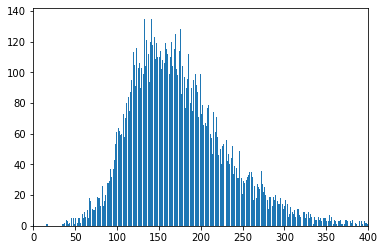

In [16]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.bar(text_len_counter.keys(), text_len_counter.values(), )
plt.xlim(0, 400);

In [17]:
len([l for l in text_lens if l < 300]) / len(text_lens)

0.9604

Распределение длин заголовков

15

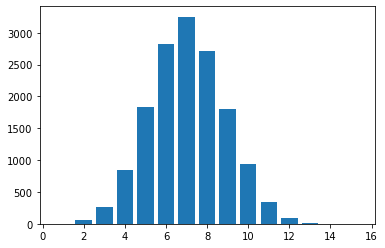

In [18]:
plt.bar(title_len_counter.keys(), title_len_counter.values());
np.max(title_lens)

In [7]:
# объединение заголовка и текста статьи (необязательно)
texts = [title + text for title, text in zip(titles, texts)]
data_test[1][:] = [title + text for title, text in zip(data_test[1], data_test[2])]

In [8]:
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
russian_stopwords = stopwords.words("russian")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lesha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

# перед использванием списки слов будут объединены в одну строку
tfidf = TfidfVectorizer(preprocessor=' '.join, stop_words=russian_stopwords) 
X_train = tfidf.fit_transform(texts) # требует лист из строк

In [10]:
from gensim.models import Word2Vec

nemb = 300 # размер вектора слова
w2v_model = Word2Vec(min_count=1, window=5, size=nemb, sample=6e-5, alpha=0.03, min_alpha=0.0004, negative=20, workers=6)

w2v_model.build_vocab(texts) # требует список из списков токенов

In [62]:
w2v_model.train(texts, total_examples=w2v_model.corpus_count, epochs=30)

(47213678, 82319220)

In [63]:
# 10 наиболее семантически близких слов
w2v_model.wv.most_similar('газета')

[('издание', 0.6300684213638306),
 ('коммерсантъ', 0.520862877368927),
 ('коммерсант', 0.5184797048568726),
 ('ида', 0.5050088763237),
 ('известие', 0.5015398263931274),
 ('ведомость', 0.4996801018714905),
 ('таблоид', 0.4806196391582489),
 ('рбк', 0.47593629360198975),
 ('гаарец', 0.47068530321121216),
 ('неназванный', 0.46755051612854004)]

In [64]:
# построение словаря: слово -> вектор длины nemb
embedding_matrix = np.zeros((len(tfidf.vocabulary_), nemb), dtype=np.float32)
c = 0
for word, i in tfidf.vocabulary_.items():
    if word in w2v_model:
        embedding_matrix[i] = w2v_model[word]
    else:
        c += 1

<ipython-input-64-6a6aa79c3482>:4: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if word in w2v_model:
<ipython-input-64-6a6aa79c3482>:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_matrix[i] = w2v_model[word]


In [65]:
# вместо простого усреднения последовательности погруженных векторов
# будем использовать усреднение с весами tf-idf 
X_train = X_train @ embedding_matrix

In [40]:
# Логистическая регрессия с подбором оптимальных гиперпараметров
# Без заголовков
from sklearn.linear_model import  LogisticRegression
from sklearn.model_selection import GridSearchCV
import multiprocessing

#n_jobs = multiprocessing.cpu_count()-1
params = {'C': [0.01, 0.1, 1], 
          'multi_class': ['ovr', 'multinomial']}

clf = LogisticRegression(max_iter=1000, random_state=42)
grid_LogReg = GridSearchCV(clf, params, verbose=5, n_jobs=5)
grid_LogReg.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:   58.2s
[Parallel(n_jobs=5)]: Done  28 out of  30 | elapsed:  3.8min remaining:   16.0s
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:  3.8min finished


GridSearchCV(estimator=LogisticRegression(max_iter=1000, random_state=42),
             n_jobs=5,
             param_grid={'C': [0.01, 0.1, 1],
                         'multi_class': ['ovr', 'multinomial']},
             verbose=5)

In [70]:
from sklearn.metrics import classification_report

y_test = [target_dict[key] for key in data_test[0]]
X_test = tfidf.transform(data_test[1]) @ embedding_matrix
y_pred = grid_LogReg.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred, target_names=target_dict.keys()))
grid_LogReg.best_params_

              precision    recall  f1-score   support

       sport       0.96      0.98      0.97       423
     culture       0.93      0.79      0.85       426
     science       0.95      0.51      0.66       466
       media       0.67      0.80      0.73       403
   economics       0.71      0.95      0.81       426
        life       0.71      0.87      0.78       415
      forces       0.72      0.85      0.78       245
      travel       0.84      0.69      0.76        54
       style       0.93      0.75      0.83        52
    business       0.50      0.08      0.13        90

    accuracy                           0.79      3000
   macro avg       0.79      0.73      0.73      3000
weighted avg       0.81      0.79      0.78      3000



{'C': 0.01, 'multi_class': 'ovr'}

In [71]:
# С заголовками
clf = LogisticRegression(C=0.01, multi_class='ovr', max_iter=1000, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=target_dict.keys()))

              precision    recall  f1-score   support

       sport       0.97      0.97      0.97       423
     culture       0.93      0.90      0.91       426
     science       0.89      0.83      0.86       466
       media       0.82      0.87      0.84       403
   economics       0.86      0.89      0.87       426
        life       0.84      0.87      0.85       415
      forces       0.78      0.89      0.83       245
      travel       0.87      0.72      0.79        54
       style       0.84      0.83      0.83        52
    business       0.67      0.42      0.52        90

    accuracy                           0.87      3000
   macro avg       0.85      0.82      0.83      3000
weighted avg       0.87      0.87      0.87      3000



In [ ]:
# Метод опорных векторов с подбором оптимальных гиперпараметров
# Без заголовков
from sklearn.svm import SVC

params = {'C': [0.01, 0.1, 1],
         'kernel': ['linear', 'poly', 'rbf']}

clf = SVC(decision_function_shape='ovo', random_state=42)
grid_SVM = GridSearchCV(clf, params, n_jobs=5)
grid_SVM.fit(X_train, y_train)

In [52]:
y_pred = grid_SVM.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred, target_names=target_dict.keys()))
grid_SVM.best_params_

              precision    recall  f1-score   support

       sport       0.97      0.98      0.98       423
     culture       0.93      0.91      0.92       426
     science       0.92      0.80      0.86       466
       media       0.82      0.87      0.84       403
   economics       0.84      0.92      0.88       426
        life       0.84      0.87      0.86       415
      forces       0.78      0.91      0.84       245
      travel       0.91      0.72      0.80        54
       style       0.88      0.85      0.86        52
    business       0.69      0.34      0.46        90

    accuracy                           0.87      3000
   macro avg       0.86      0.82      0.83      3000
weighted avg       0.87      0.87      0.87      3000



{'C': 1, 'kernel': 'rbf'}

In [73]:
# С заголовками
clf_ = SVC(C=1, kernel='rbf', decision_function_shape='ovr', random_state=42)
clf_.fit(X_train, y_train)
y_pred_ = clf_.predict(X_test)
print(classification_report(y_test, y_pred_, target_names=target_dict.keys()))

              precision    recall  f1-score   support

       sport       0.97      0.98      0.98       423
     culture       0.94      0.91      0.92       426
     science       0.91      0.81      0.86       466
       media       0.82      0.88      0.85       403
   economics       0.84      0.92      0.88       426
        life       0.84      0.87      0.85       415
      forces       0.78      0.91      0.84       245
      travel       0.89      0.74      0.81        54
       style       0.88      0.81      0.84        52
    business       0.71      0.33      0.45        90

    accuracy                           0.87      3000
   macro avg       0.86      0.82      0.83      3000
weighted avg       0.87      0.87      0.87      3000



#### Классификация с помощью нейронной сети в файле `Task_6_2.ipynb`